In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
rental_data = pd.read_csv("../b. Datasets/Bike Rental Demand/BikeRentalDemand.csv")

rental_data.head()

,index,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,demand
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,01-01-2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,01-01-2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


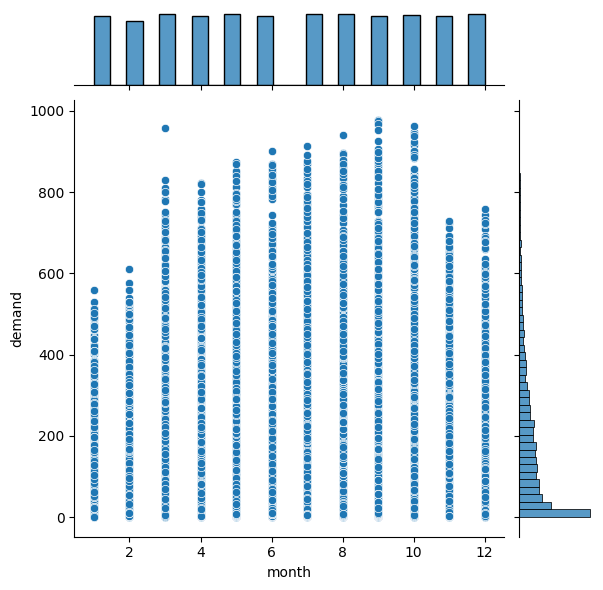

In [3]:
sns.jointplot(data=rental_data, x="month", y="demand")

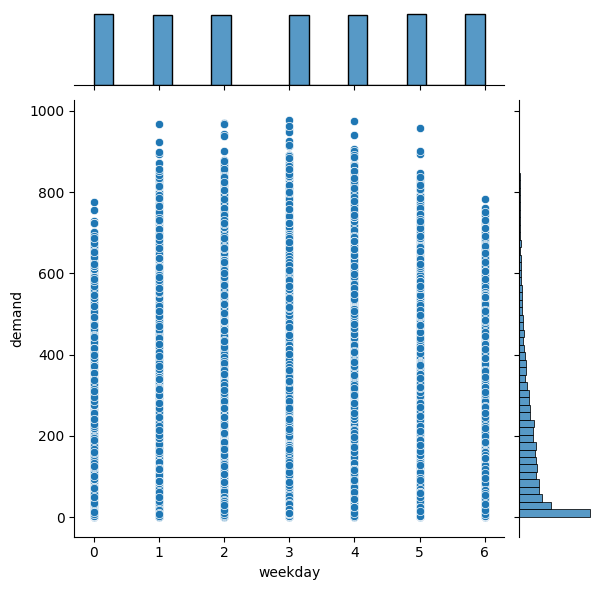

In [4]:
sns.jointplot(data=rental_data, x="weekday", y="demand")

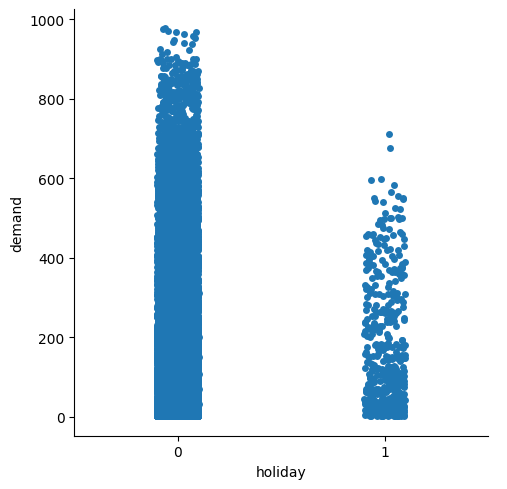

In [5]:
sns.catplot(data=rental_data, x='holiday', y='demand')

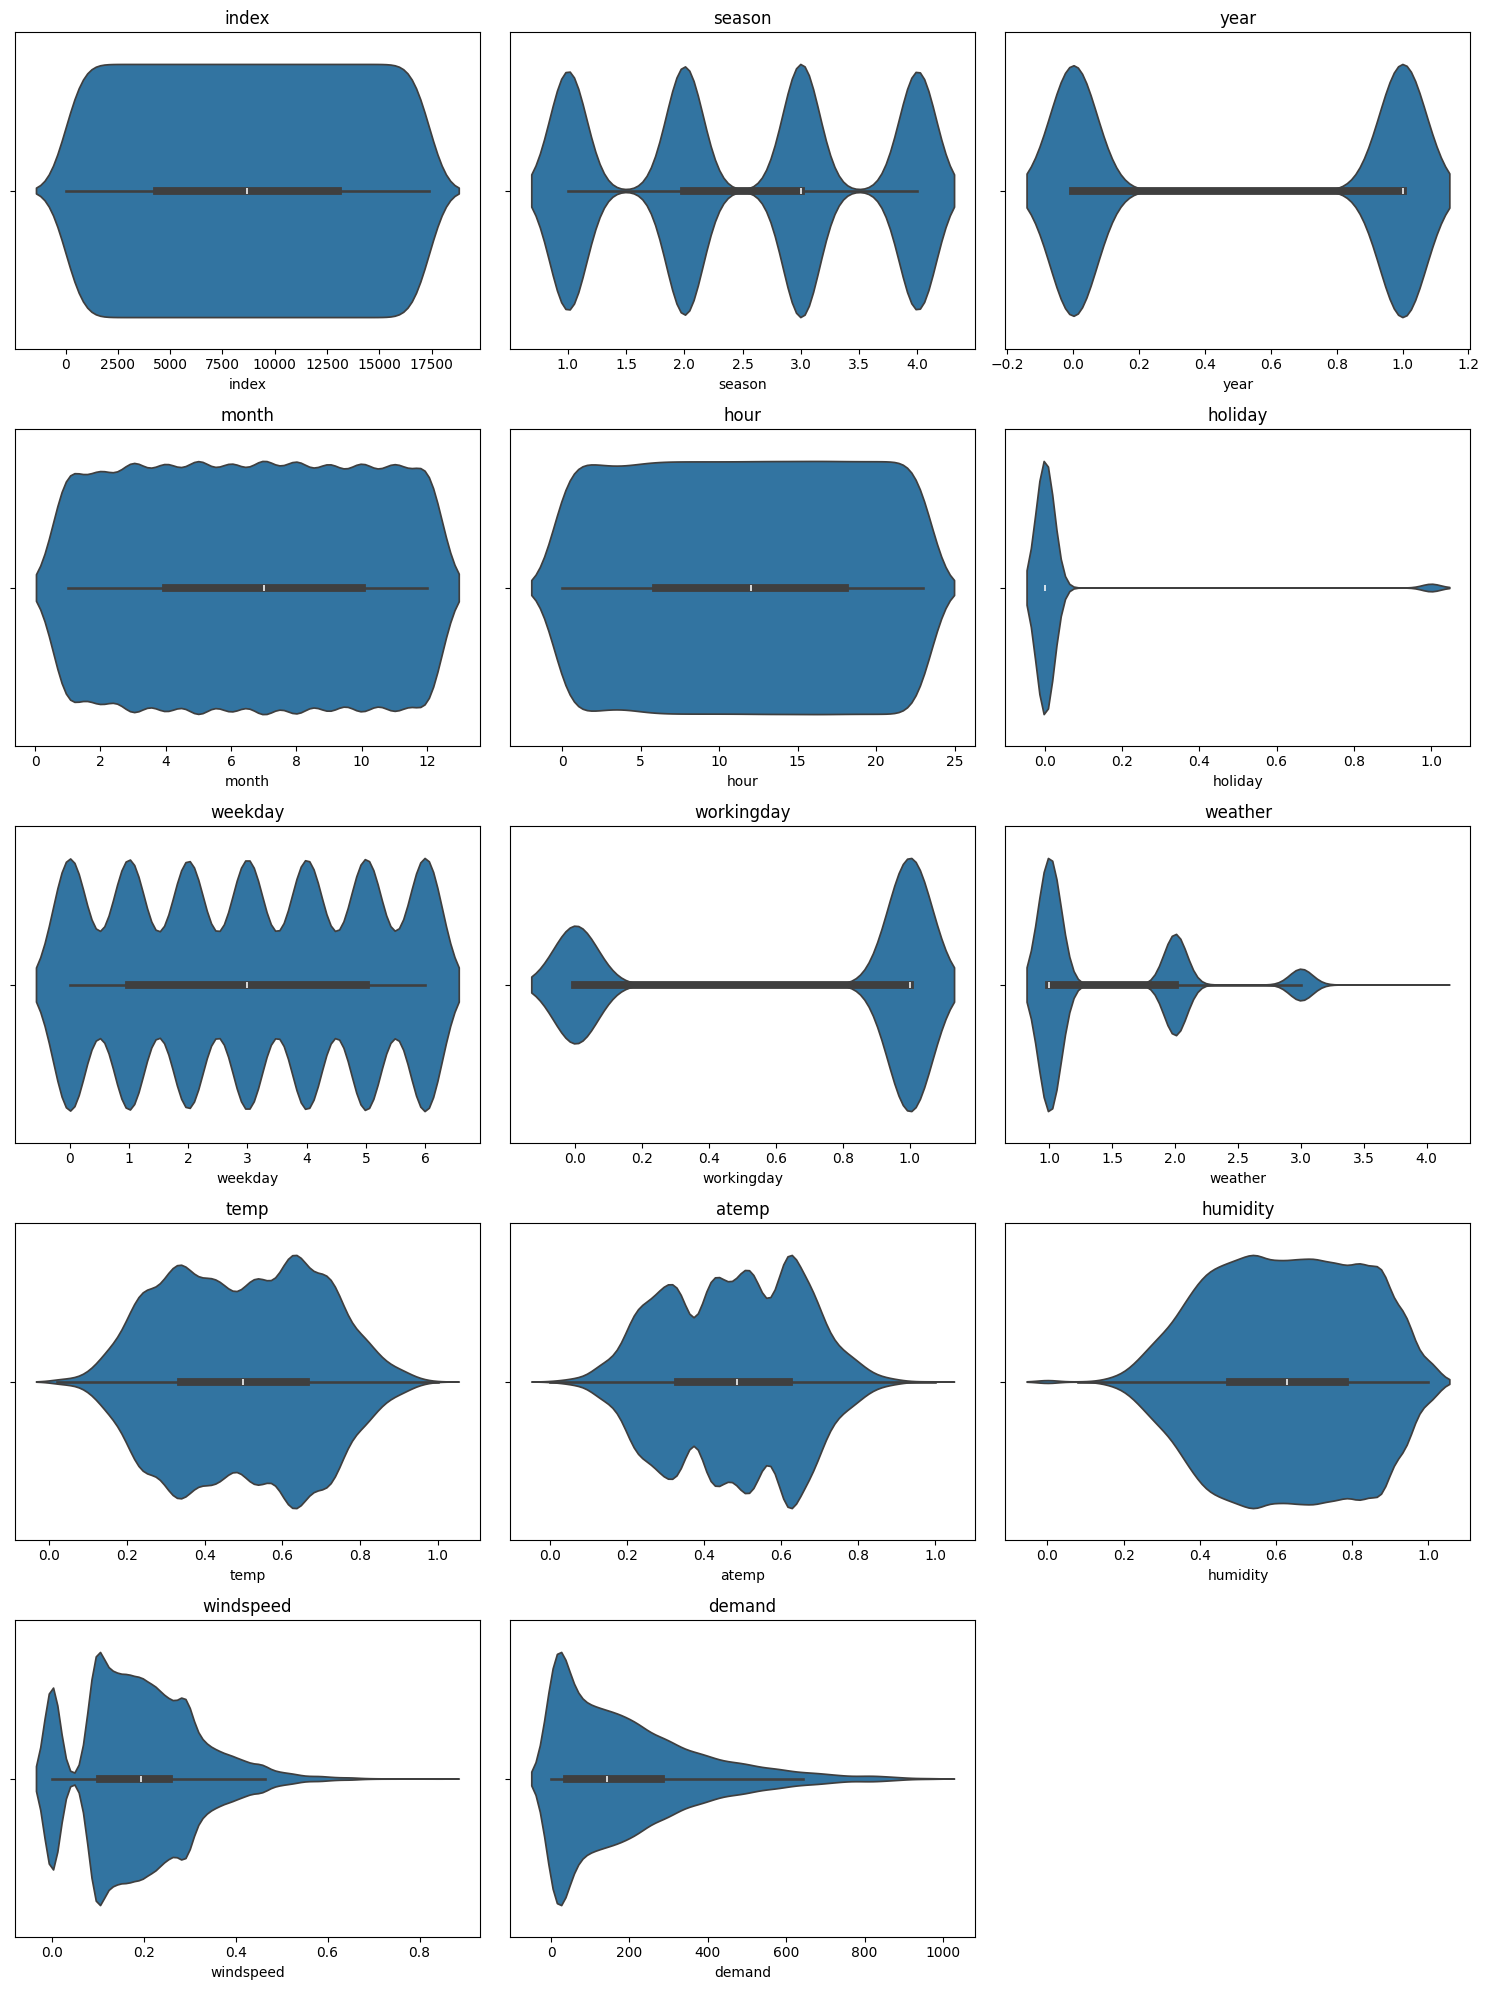

In [6]:
numerical_data = rental_data.select_dtypes(include="number")

num_cols = 3
num_rows = (len(numerical_data.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_data.columns):
    sns.violinplot(data=rental_data, x=col, ax=axes[idx])
    axes[idx].set_title(col)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [7]:
rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  int64  
 3   year        17379 non-null  int64  
 4   month       17379 non-null  int64  
 5   hour        17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weather     17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  humidity    17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  demand      17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


In [8]:
numerical_data = rental_data.select_dtypes(include="number")
Q1 = numerical_data.quantile(0.25)
Q3 = numerical_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

rental_data = rental_data[~ ((numerical_data > upper_bound) | (numerical_data < lower_bound)).any(axis=1)]
rental_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16029 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16029 non-null  int64  
 1   date        16029 non-null  object 
 2   season      16029 non-null  int64  
 3   year        16029 non-null  int64  
 4   month       16029 non-null  int64  
 5   hour        16029 non-null  int64  
 6   holiday     16029 non-null  int64  
 7   weekday     16029 non-null  int64  
 8   workingday  16029 non-null  int64  
 9   weather     16029 non-null  int64  
 10  temp        16029 non-null  float64
 11  atemp       16029 non-null  float64
 12  humidity    16029 non-null  float64
 13  windspeed   16029 non-null  float64
 14  demand      16029 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


In [9]:
rental_data.isna().sum().sum()

0

In [10]:
rental_data.isna().sum() / len(rental_data) * 100

index         0.0
date          0.0
season        0.0
year          0.0
month         0.0
hour          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
demand        0.0
dtype: float64

In [11]:
rental_data.dropna(inplace=True)

<Axes: >

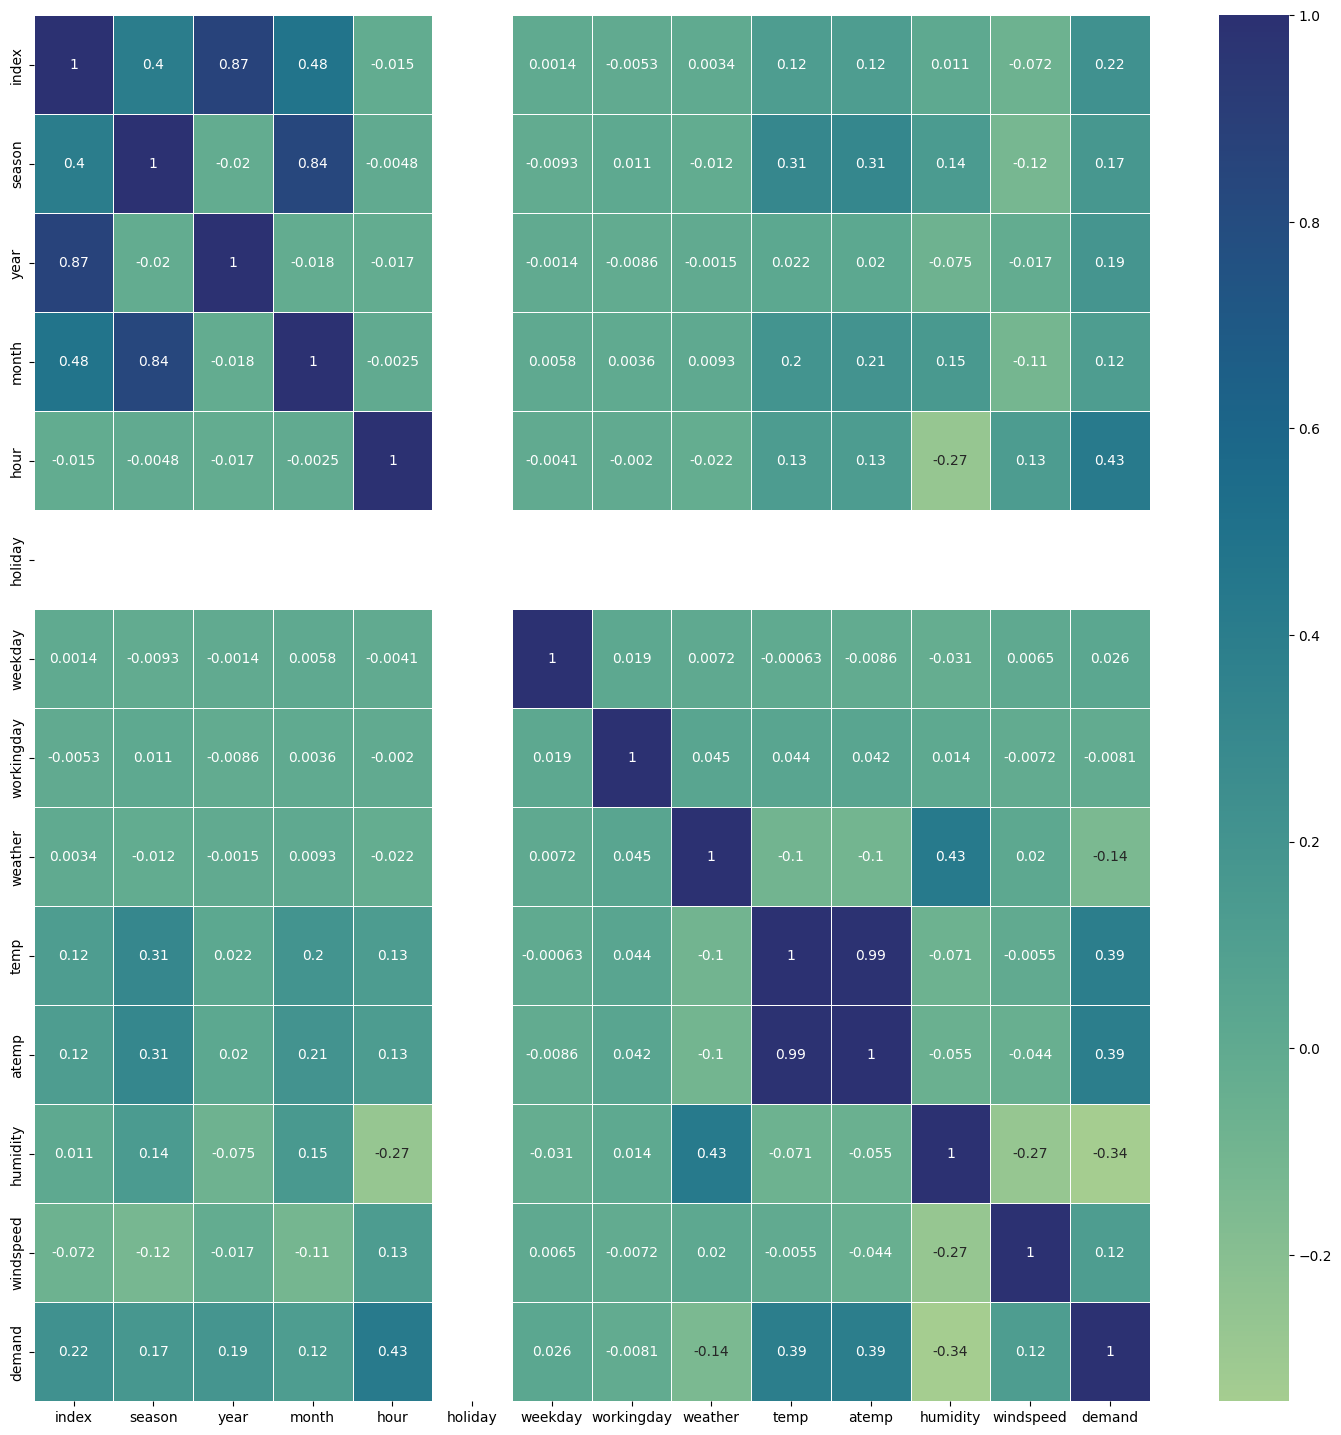

In [12]:
numerical_data = rental_data.select_dtypes(include="number")
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, cmap="crest", annot=True, linewidths=0.7)

In [13]:
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
0,index,1992.670642
2,year,752.404988
3,month,601.136963
10,atemp,377.512205
9,temp,337.382142
1,season,22.109899
11,humidity,14.164091
8,weather,7.748293
4,hour,4.333926
13,demand,3.695594


In [14]:
rental_data.drop(labels="index", axis=1, inplace=True)
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
9,atemp,369.962192
8,temp,332.218582
0,season,22.080725
2,month,15.722460
10,humidity,13.719127
7,weather,7.739691
3,hour,4.319071
12,demand,3.695126
11,windspeed,3.432244
6,workingday,3.205306


In [15]:
rental_data.drop(labels="atemp", axis=1, inplace=True)
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
0,season,22.018574
2,month,15.719291
9,humidity,12.731650
8,temp,9.084058
7,weather,7.731515
3,hour,4.264671
11,demand,3.686028
10,windspeed,3.386297
6,workingday,3.195777
5,weekday,3.052377


In [16]:
rental_data.drop(labels="season", axis=1, inplace=True)
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
8,humidity,12.456988
7,temp,8.417468
6,weather,7.729750
1,month,4.952937
2,hour,4.263717
10,demand,3.662524
9,windspeed,3.386082
5,workingday,3.192683
4,weekday,3.052336
0,year,1.977847


In [17]:
rental_data.drop(labels="humidity", axis=1, inplace=True)
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
7,temp,7.488364
6,weather,4.943964
1,month,4.417718
2,hour,4.259150
9,demand,3.414547
8,windspeed,3.384776
5,workingday,3.124700
4,weekday,2.983431
0,year,1.957046
3,holiday,NaN


In [18]:
rental_data.drop(labels="temp", axis=1, inplace=True)
numerical_data = rental_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
6,weather,4.772936
2,hour,4.218771
1,month,3.826847
7,windspeed,3.317338
8,demand,3.035105
5,workingday,3.004172
4,weekday,2.926683
0,year,1.951407
3,holiday,NaN


In [19]:
numerical_data = rental_data.select_dtypes(include="number")
numerical_data.skew()

year          0.052053
month        -0.005866
hour          0.029763
holiday       0.000000
weekday      -0.033396
workingday   -0.869294
weather       1.207053
windspeed     0.230974
demand        0.926592
dtype: float64

In [20]:
pt = PowerTransformer(method="yeo-johnson")
rental_data["demand"] = pt.fit_transform(rental_data[["demand"]])

In [21]:
numerical_data = rental_data.select_dtypes(include="number")
numerical_data.skew()

year          0.052053
month        -0.005866
hour          0.029763
holiday       0.000000
weekday      -0.033396
workingday   -0.869294
weather       1.207053
windspeed     0.230974
demand       -0.170549
dtype: float64

In [22]:
numerical_data = rental_data.select_dtypes(include="number")
numerical_data.std()

year          0.499846
month         3.435285
hour          6.981685
holiday       0.000000
weekday       2.017561
workingday    0.458579
weather       0.639590
windspeed     0.111872
demand        1.000031
dtype: float64

In [23]:
rental_data.drop(labels="holiday", axis=1, inplace=True)

In [24]:
rental_data

,date,year,month,hour,weekday,workingday,weather,windspeed,demand
0,01-01-2011,0,1,0,6,0,1,0.0000,-1.249459
1,01-01-2011,0,1,1,6,0,1,0.0000,-0.787772
2,01-01-2011,0,1,2,6,0,1,0.0000,-0.914332
3,01-01-2011,0,1,3,6,0,1,0.0000,-1.334480
4,01-01-2011,0,1,4,6,0,1,0.0000,-1.943662
...,...,...,...,...,...,...,...,...,...
17374,31-12-2012,1,12,19,1,1,2,0.1642,-0.009381
17375,31-12-2012,1,12,20,1,1,2,0.1642,-0.245582
17376,31-12-2012,1,12,21,1,1,1,0.1642,-0.236917
17377,31-12-2012,1,12,22,1,1,1,0.1343,-0.520101


In [25]:
numerical_data = rental_data.select_dtypes(include="number")
standard_scaler = StandardScaler()
rental_data[numerical_data.columns] = standard_scaler.fit_transform(numerical_data)
rental_data

,date,year,month,hour,weekday,workingday,weather,windspeed,demand
0,01-01-2011,-0.974314,-1.612768,-1.634435,1.472766,-1.524965,-0.670915,-1.628658,-1.249459
1,01-01-2011,-0.974314,-1.612768,-1.491199,1.472766,-1.524965,-0.670915,-1.628658,-0.787772
2,01-01-2011,-0.974314,-1.612768,-1.347962,1.472766,-1.524965,-0.670915,-1.628658,-0.914332
3,01-01-2011,-0.974314,-1.612768,-1.204726,1.472766,-1.524965,-0.670915,-1.628658,-1.334480
4,01-01-2011,-0.974314,-1.612768,-1.061490,1.472766,-1.524965,-0.670915,-1.628658,-1.943662
...,...,...,...,...,...,...,...,...,...
17374,31-12-2012,1.026363,1.589395,1.087056,-1.005552,0.655753,0.892635,-0.160860,-0.009381
17375,31-12-2012,1.026363,1.589395,1.230292,-1.005552,0.655753,0.892635,-0.160860,-0.245582
17376,31-12-2012,1.026363,1.589395,1.373529,-1.005552,0.655753,-0.670915,-0.160860,-0.236917
17377,31-12-2012,1.026363,1.589395,1.516765,-1.005552,0.655753,-0.670915,-0.428139,-0.520101


In [26]:
rental_data.select_dtypes(include="object").head()

,date
0,01-01-2011
1,01-01-2011
2,01-01-2011
3,01-01-2011
4,01-01-2011


In [27]:
ordinal_encoder = OrdinalEncoder()
rental_data["date"] = ordinal_encoder.fit_transform(rental_data[["date"]])

In [28]:
X = rental_data.drop(labels=["demand"], axis=1)
y = rental_data["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
X_train_updated = sm.add_constant(X_train)

In [29]:
model = sm.OLS(y_train, X_train_updated).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     775.7
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:36:20   Log-Likelihood:                -13479.
No. Observations:               11220   AIC:                         2.698e+04
Df Residuals:                   11211   BIC:                         2.704e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0237      0.015      1.558      0.119      -0.006       0.054
date       -6.804e-05   3.73e-05     -1.825      0.068      -0.000    5.05e-06
year           0.1677      0.008     22.055      0.000       0.153       0.183
month          0.1315      0.008     17.128      0.000       0.116       0.147
hour           0.5321      0.008     69.504      0.000       0.517       0.547
weekday        0.0307      0.008      4.048      0.000       0.016       0.046
workingday    -0.0081      0.008     -1.065      0.287      -0.023       0.007
weather       -0.1227      0.008    -16.008      0.000      -0.138      -0.108
windspeed      0.0833      0.008     10.807      0.000       0.068       0.098
==============================================================================
Omnibus:                      315.133   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.258
Skew:                           0.028   Prob(JB):                     3.19e-34
Kurtosis:                       2.428   Cond. No.                         819.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

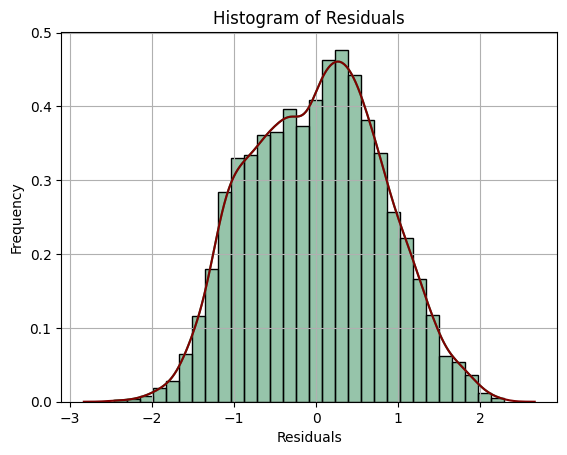

In [30]:
residuals = model.resid

sns.histplot(data=residuals, bins=30, kde=True, stat='density', color='#2E8B57')
sns.kdeplot(data=residuals, color='#800000')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid()
plt.show()

In [31]:
residuals.skew()

0.028110761752085427

In [32]:
forward_features = sfs(estimator=LinearRegression(), k_features=6, forward=True, cv=5)
forward_features = forward_features.fit(X_train, y_train)
forward_features.k_feature_names_, forward_features.feature_names, forward_features.k_score_

(('year', 'month', 'hour', 'weekday', 'weather', 'windspeed'),
 ['date',
  'year',
  'month',
  'hour',
  'weekday',
  'workingday',
  'weather',
  'windspeed'],
 0.35425355184289814)

In [33]:
best_features_X = rental_data.drop(labels=["demand", "date", "workingday"], axis=1)
y = rental_data["demand"]
X_train, X_test, y_train, y_test = train_test_split(best_features_X, y, test_size=0.3, random_state=0, shuffle=True)
X_train_updated = sm.add_constant(X_train)

In [34]:
updated_model = sm.OLS(y_train, X_train_updated).fit()
updated_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     1033.
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:36:21   Log-Likelihood:                -13482.
No. Observations:               11220   AIC:                         2.698e+04
Df Residuals:                   11213   BIC:                         2.703e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.008     -0.040      0.968      -0.015       0.015
year           0.1676      0.008     22.037      0.000       0.153       0.182
month          0.1308      0.008     17.055      0.000       0.116       0.146
hour           0.5319      0.008     69.478      0.000       0.517       0.547
weekday        0.0306      0.008      4.042      0.000       0.016       0.045
weather       -0.1232      0.008    -16.090      0.000      -0.138      -0.108
windspeed      0.0832      0.008     10.790      0.000       0.068       0.098
==============================================================================
Omnibus:                      318.618   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.376
Skew:                           0.028   Prob(JB):                     1.82e-34
Kurtosis:                       2.426   Cond. No.                         1.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
X = rental_data.drop(labels=["demand"], axis=1)
y = rental_data["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print('Train RMSE', train_rmse)
print('Test RMSE', test_rmse)

Train RMSE 0.8044789473716504
Test RMSE 0.7962503485923524


In [37]:
y_test_pred

array([-1.00544428,  0.42973915, -0.62167327, ...,  0.07936423,
        0.04944621,  0.40037506])

In [38]:
y_test_pred_padded = np.zeros((4809, 8))
y_test_pred_padded[:, 7] = y_test_pred.flatten()
y_test_pred_original = standard_scaler.inverse_transform(y_test_pred_padded)
y_test_pred = y_test_pred_original[:, 7]
y_test_pred = y_test_pred.reshape(-1, 1)
y_test_pred = pt.inverse_transform(y_test_pred)

In [39]:
y_test_pred = y_test_pred.flatten()

In [40]:
submission_dataframe = pd.DataFrame({
    'Index': X_test.index,
    'demand': y_test_pred
})

submission_dataframe.sort_values(by='Index', ascending=True, inplace=True)

In [41]:
submission_dataframe_file = '../d. Output Files/BikeRentalDemand/BikeRentalDemand_Prediction.csv'
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: BikeRentalDemand_Prediction.csv
